# Housing Price Prediction Project Coding Summary

This is a summary of the code I wrote as a part of my group's final project for DS-GA-1001 Introduction to Data Science. This project strived to create a predictive model for individual housing units in NYC using data from 2013-2019. I ommitted the code we used to perform exploratory analysis on the various datasets, the code we used to merge the datasets together, and the code for constructing our predictive models as these were portions that I worked on in tandem with others. The below code was exclusively written by me. In summary the datasets we used were rolling sales data, valuation assessment data, and macro and demographic data. [For a full description of the project and its findings](https://github.com/pgladkevich/NYU/blob/main/The_Unsupervised_Learners_DSGA_1001_Final_Project.pdf).

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
pd.options.display.max_columns = None
above = '../../../'

# Read in the final merged pickle file
data = pd.read_pickle(above + 'merged-sales-val-macro-dem-crime.pkl')

# Columns to drop
drop = ["s_neighborhood", 
        "s_building_class_category", 
        "s_block", 
        "s_lot", 
        "s_address", 
        "s_apt_number", 
        "s_gross_sqft", 
        "s_tax_class_at_sale", 
        "s_residential_units", 
        "s_commercial_units",
        "s_year", 
        "v_bldgcl", 
        "v_bldfront", 
        "a_year_month", 
        "s_borough_code", 
        "c_year_month", 
        "s_sale_date",
        "s_sale_month", 
        "s_sale_year"
       ]

data.drop(drop, axis =1, inplace=True)

# Print the number of rows in the given dataframe
def check_rows(df):
    print("The number of rows remaining in the dataset is: {}".format(
        df.shape[0])
         )

check_rows(data)

The number of rows remaining in the dataset is: 401790


After dropping either redundant columns, or information we were not going to use and post-merge we are left with a total of around 400,000 rows; however, this left us with a lot of sales that were related to multiple units being sold at once in some cases even entire buildings. Our primary interest was in predicting retail housing price not commercial investment into the housing market so we chose to focus on single unit sales. We also noticed outliers on the lower and upper ends. We decided that a cutoff of around the upper 1% and a flat cutoff of 50,000 (around the lowest value we found for a single unit sale in NYC based off of searching online) was prudent. This way we could eliminate values clustered about zero which were likely passes of titles and what was potentially two mistakes in data entry for the high properties (We searched their bbls and determined these properties were not valued correctly).

In [40]:
# Removal of non single unit sales
data = data[data['s_total_units'] == 1]
# We noticed outliers on the lower and upper end.
data = data[data['s_sale_price'] > 50000]
data = data[data['s_sale_price'] != 67602825]
data = data[data['s_sale_price'] != 147000000]
data.drop(["s_total_units"], axis =1, inplace=True)
check_rows(data)

The number of rows remaining in the dataset is: 164477


In [41]:
# Create histogram of the # of units in percentile of the top 1% of column's values
def hist_col(data, col, b):
    data99_max = data[data[col] <= np.percentile(data[col],99)][col].max()
    plt.hist(data[col],bins=b, range=(0, np.percentile(data[col],99)))
    plt.xlabel(f'Price in % of {data99_max}')
    plt.ylabel("Count of units sold")
    plt.title('Histogram of total ' + col)
    plt.show()

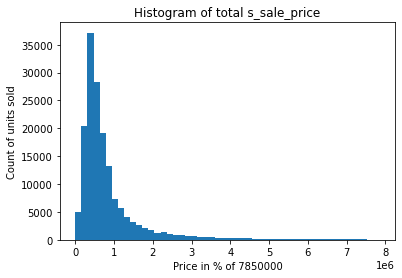

In [13]:
hist_col(data, 's_sale_price', 50)

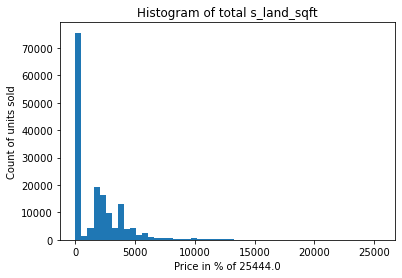

In [14]:
hist_col(data, "s_land_sqft", 50)

In [44]:
# Number of 0 values in sales s_land_sqft
print(f'Zero values for sqft of land in Sales: {((data.s_land_sqft) == 0).sum()}')
# Number of 0 values in valuation lotfront or lotdepth
print(f'Zero values for sqft in Valuation: {((data.v_ltfront * data.v_ltdepth) == 0).sum()}')
# Where we have 0 values in either sales or valuation
miss_area = data[(data.s_land_sqft == 0) 
                 & ((data.v_ltfront * data.v_ltdepth) == 0)]
print(f'Total number of missing values for area that we can not impute {miss_area.shape[0]}')

Zero values for sqft of land in Sales: 75111
Zero values for sqft in Valuation: 62919
Total number of missing values for area that we can not impute 60804


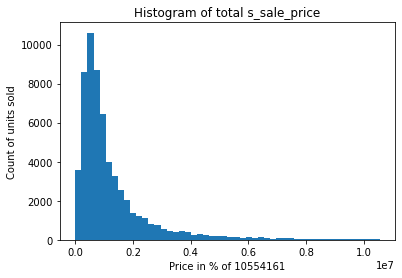

In [16]:
# Histogram of sales with missing values for square footage
hist_col(miss_area, 's_sale_price', 50)

## Imputing Missing Square Footage Values

After noticing that there were unit sales that didn't have a value for square footage we decided to impute the missing value using the multiplication of lotfront and lotdepth

In [17]:
# Remove all rows that we can not impute
data.drop(axis =0, index = miss_area.index, inplace=True)
# Get rid of the original index values that are no longer applicable
data = data.reset_index(drop=True)

In [45]:
data["prod_vf_vd"] = data.v_ltfront * data.v_ltdepth
def create_imputed_land_area(row):
    if row["s_land_sqft"] == 0:
        return row["prod_vf_vd"]
    else:
        return row["s_land_sqft"]
data["imputed_land_area"] = data.apply(
    lambda row: create_imputed_land_area(row), axis=1)

In [46]:
# Sanity check that there are no zero values for area
print(f'Count of missing area values:{(data.imputed_land_area == 0).sum()}')

Count of missing area values:60804


In [47]:
drop = ["s_land_sqft", "v_ltfront", "v_ltdepth", "prod_vf_vd"]
data.drop(drop, axis =1, inplace=True)
check_rows(data)

The number of rows remaining in the dataset is: 164477


In [48]:
# Double check that there are no missing values anywhere
data.columns[data.isnull().sum() != 0]

Index(['v_stories', 'v_latitude', 'v_longitude', 'v_nta'], dtype='object')

## Last Missing Values

We noticed that there were still some remaining columns with null values. We needed to resolve this prior to creating models as many models can not handle null values.

In [49]:
# Retrieve the index of the missing values for stories
miss_v_stories = data.v_stories[data.v_stories.isnull()].index.to_numpy()
# Convert the number of stories to one where it is null
data.at[miss_v_stories, "v_stories"] = 1

# Do the same with missing latitude and longitude
miss_v_latitude = data.v_latitude[data.v_latitude.isnull()].index.to_numpy()
miss_v_longitude = data.v_longitude[data.v_longitude.isnull()].index.to_numpy()
data.drop(axis =0, index = miss_v_latitude, inplace=True)

In [50]:
check_rows(data)

The number of rows remaining in the dataset is: 163649


## Preventing Data Leakage 

Prior to starting the modeling and tuning process, we noticed a possible source of leakage: for data instances with the same unique property identifier (BBL) but with different sale dates, the half of the associated features that are property-dependent would be the same, while the other half of the 11 features that were time-dependent would be variable. To prevent overfitting and control the leakage, we randomly sampled unique BBL IDs instead of instances of data. Then, when splitting the data into train and test sets and placing all instances with the same BBLs into the same dataset.

**I ommitted the code where we actually used these functions for generation of the test sets to avoid the computation time** 

In [51]:
def trainTest(dat, pct):
    '''
    Randomly splits data into train and test, takes input of
    DAT for the dataframe and PCT for percentage split.
    Returns the training set based off of the PCT value and
    1-PCT for the test set.
    '''
    dat_shuf = dat.reindex(np.random.permutation(dat.index))
    trn = dat_shuf[:int(np.floor(dat_shuf.shape[0]*pct))]
    tst = dat_shuf[int(np.floor(dat_shuf.shape[0]*pct)):]
    return [trn, tst]

def rand_keep_uniqbbl(data, pct):
    '''
    Randomly splits data into train and test, takes input of
    DAT for the dataframe and PCT for percentage split.
    Returns the training set based off of the PCT value and
    1-PCT for the test set. The percentages will not be exact
    as it will group like values of bbl together.
    '''
    dup_bbl = data.groupby('s_bbl').count().v_fullval[
        (data.groupby('s_bbl').count().v_fullval > 1)
    ].index.to_numpy()
    d_dup = data[data.s_bbl.isin(dup_bbl)]
    d_dup_selected = np.random.choice(dup_bbl, int(dup_bbl.shape[0] * pct))
    d_uniq = data[~data.s_bbl.isin(dup_bbl)]

    small_uniq, big_uniq = trainTest(d_uniq, pct)
    small_dup = d_dup[d_dup.s_bbl.isin(d_dup_selected)]
    big_dup = d_dup[~d_dup.s_bbl.isin(d_dup_selected)]
    small = pd.concat([small_uniq, small_dup], axis = 0)
    big = pd.concat([big_uniq, big_dup], axis = 0)  

    return small, big

## Ordinal Encoding

Regression algorithms cannot process categorical data,and features on very different scales can impact analysis. To remedy this, the two categorical features of “Neighborhood Tabulation Area” and “Building Class Code” were converted to numerical values via ordinal encoding.

**I commented out the code for the application of the function to avoid the computation time** 

In [21]:
# Find the categorical columns to convert
cat_col = data.select_dtypes(exclude=['int64', 'float']).columns.to_list()
print(cat_col)
cat_col.remove('s_bbl')

['s_building_class_at_sale', 's_bbl', 'v_nta']


In [22]:
# We have to use ordinal encoding to transform the categorical to numerical
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

# Create transformation function, input data and list of categorical columns, returns replace map
def ordinal_map(df, cols):
    replace_map = {}
    encoder = OrdinalEncoder()
    encoder.fit(data[cols])
    cats = encoder.categories_
    for i in range(len(cols)):
        c =  data[cat_col[i]].unique().tolist()        
        o = list(map(lambda x:[x], c)) 
        result = encoder.fit_transform(o)
        cat = cats[i]
        replace_map[cols[i]] = {k: v for k,v in zip(cats[i], [x[0] for x in result.tolist()])}
    return replace_map

# Using the replacement map the dataframe then swaps values, but it takes a while to run
# r_map = ordinal_map(data, cat_col)
# data.replace(r_map, inplace=True)

# Correlation Heatmaps and PCA

I read in the finished pickle file from the previous steps to avoid the computation time. We observed structure in the correlation matrix and decided to do grouped PCA on the demographic and macroeconomic data.

In [27]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

data = pd.read_pickle(above + 'post_eda.pkl') 
data = data.drop('s_bbl',1)

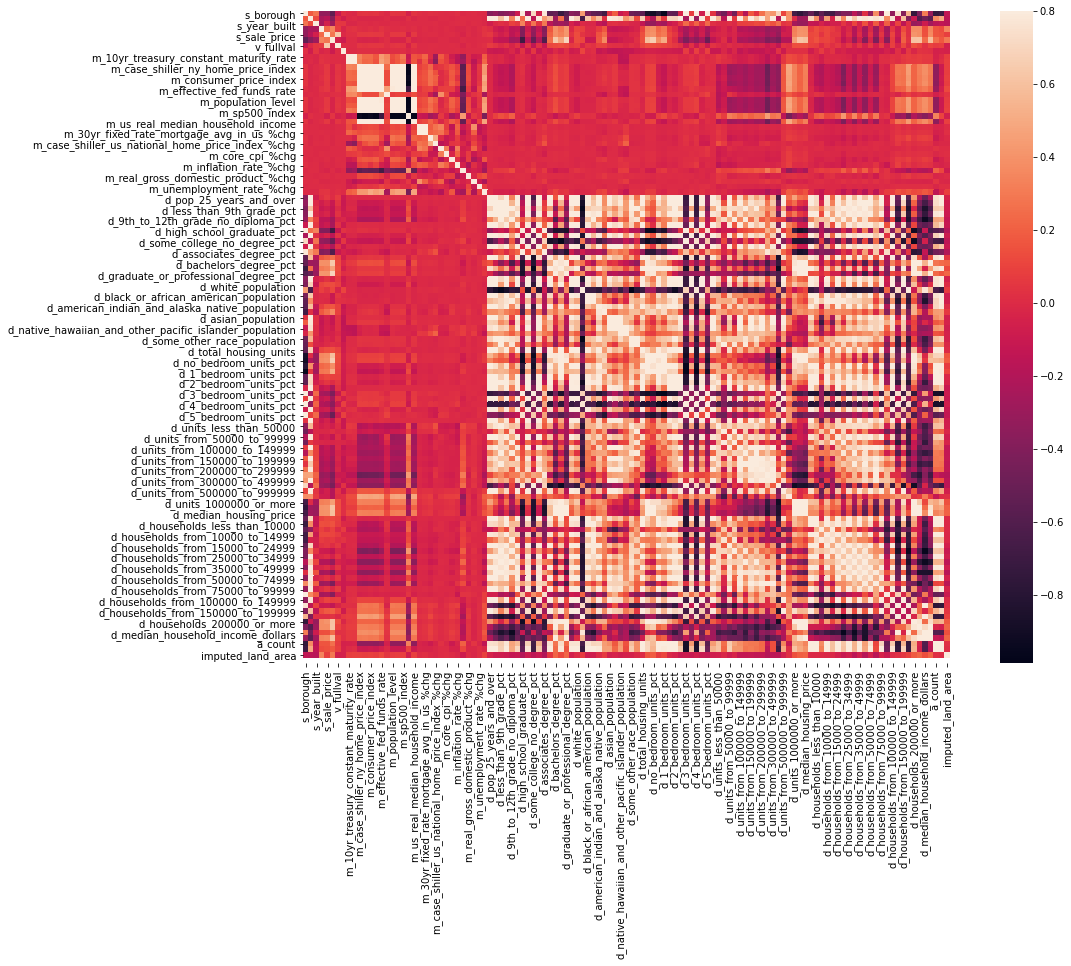

In [28]:
corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr_matrix, vmax=.8, square=True)
fig.savefig('corr_heatmap_125.png')

In [30]:
corr_with_target = corr_matrix['s_sale_price'] # Our target variable is the sale price
k = 20
top_k_corr_features = np.abs(corr_with_target).sort_values(ascending=False).head(k).index.tolist()
print(corr_with_target[top_k_corr_features])

s_sale_price                             1.000000
v_fullval                                0.633650
d_graduate_or_professional_degree_pct    0.410270
d_high_school_graduate_pct              -0.407360
d_households_200000_or_more              0.405075
d_units_1000000_or_more_pct              0.404679
d_median_housing_price                   0.399114
d_no_bedroom_units_pct                   0.396319
d_bachelors_degree_pct                   0.390473
d_no_bedroom_units                       0.380771
d_households_200000_or_more_pct          0.378494
d_associates_degree_pct                 -0.366271
d_mean_household_income_dollars          0.361046
d_some_college_no_degree_pct            -0.348239
d_units_1000000_or_more                  0.333992
s_borough                               -0.330576
d_graduate_or_professional_degree        0.326849
d_units_from_300000_to_499999_pct       -0.318391
d_1_bedroom_units_pct                    0.299252
d_units_from_200000_to_299999_pct       -0.287972


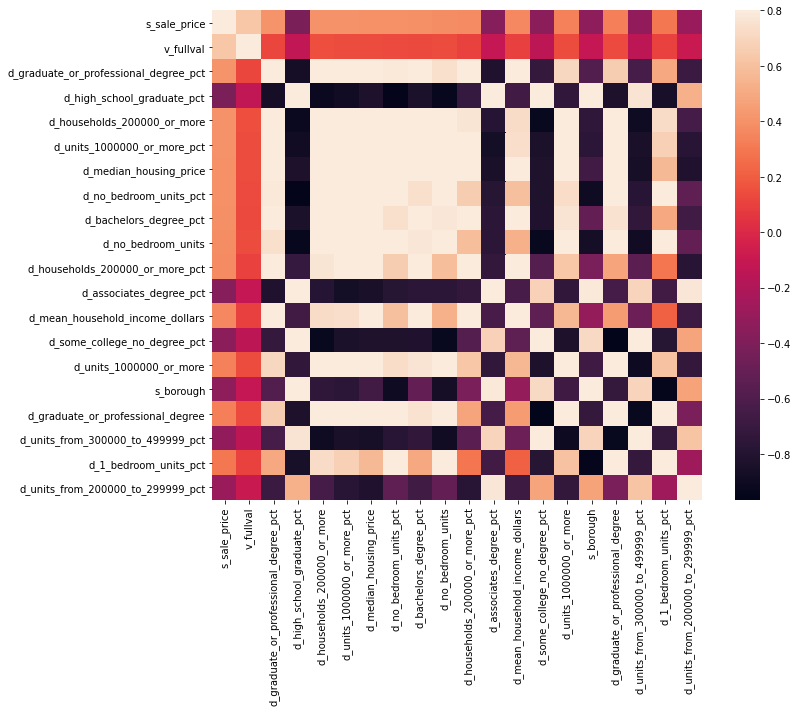

In [31]:
data_narrowed = data[top_k_corr_features] # To get data related to only the topk features for a heatmap
top_k_corr_matrix = data[top_k_corr_features].corr()
fig, ax = plt.subplots(figsize=(12, 9))
corr_heatmap_10 = sns.heatmap(top_k_corr_matrix, vmax=.8, square=True)
fig.savefig('corr_heatmap_10.png')

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = data.loc[:, data.columns != 's_sale_price']  #independent columns
y = data.loc[:, data.columns == 's_sale_price']    #target column sales price

X_m = data[[col for col in X if col.startswith('m')]] # Isolate the macroeconomic data
sc_m = StandardScaler()

sc_m.fit(X_m) # Fit the standard scaler to the macroeconomic data
scaled_X_m = sc_m.transform(X_m)
X_m_l = X_m.shape[1]

pca_m = PCA(n_components = X_m_l) # PCA analysis of the macroeconmic data
pca_m.fit(scaled_X_m)
x_m_pca = pca_m.transform(scaled_X_m)

[]

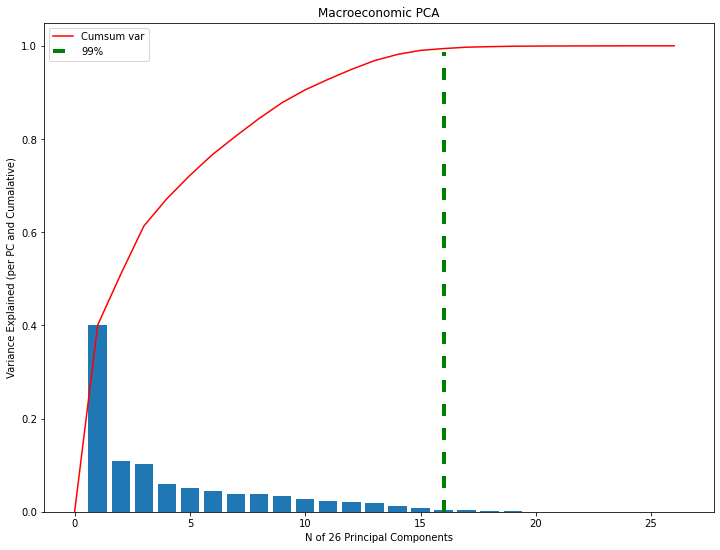

In [33]:
plt.figure(figsize=(12,9))
plt.bar(np.arange(1, X_m_l + 1),pca_m.explained_variance_ratio_[0:X_m_l])
cumsum = np.concatenate((np.array([0]),np.cumsum(pca_m.explained_variance_ratio_)), axis = 0) 
plt.plot(np.arange(0, X_m_l + 1),cumsum, color = 'r', label ='Cumsum var')
plt.axvline(x = 16, linewidth=4, color='g', dashes= (3, 3, 3, 3), ymin =0, ymax=0.94, label ='99%')
plt.ylabel("Variance Explained (per PC and Cumalative)")
plt.xlabel("N of 26 Principal Components")
plt.title("Macroeconomic PCA")
plt.legend()
plt.plot()

In [34]:
X_d = data[[col for col in X if col.startswith('d')]] # Isolate the demographic data
sc_d = StandardScaler()
sc_d.fit(X_d) # Fit the standard scaler to the demographic data
scaled_X_d = sc_d.transform(X_d)
X_d_l = X_d.shape[1]

pca_d = PCA(n_components = X_d_l) # PCA analysis of the demographic data
pca_d.fit(scaled_X_d)
x_d_pca = pca_d.transform(scaled_X_d)

[]

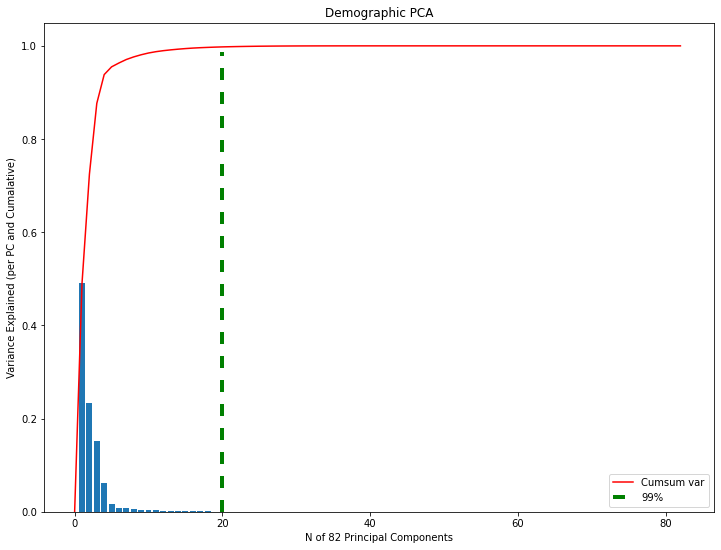

In [35]:
plt.figure(figsize=(12,9))
plt.bar(np.arange(1, X_d_l + 1),pca_d.explained_variance_ratio_[0:X_d_l])
cumsum = np.concatenate((np.array([0]),np.cumsum(pca_d.explained_variance_ratio_)), axis = 0) 
plt.plot(np.arange(0, X_d_l + 1),cumsum, color = 'r', label ='Cumsum var')
plt.axvline(x = 20, linewidth=4, color='g', dashes= (3, 3, 3, 3), ymin =0, ymax=0.94, label ='99%')
plt.ylabel("Variance Explained (per PC and Cumalative)")
plt.xlabel("N of 82 Principal Components")
plt.title("Demographic PCA")
plt.legend()
plt.plot()

The plots above show that for the macroeconomic features, 16 principal components explained 99% of the
variation in the target variable. On the other hand, 20 principal components explained 99% of the target variable
variation for the demographic features. We selected these 36 principal components as dimension-reduced features
of their respective data sets, and decreased the number of features to 46 from 120.

In [36]:
pca_m = PCA(n_components = 15)
scores_m = pca_m.fit_transform(scaled_X_m) # Reconstruct from the 15 dimensional scores 

principalDf_m = pd.DataFrame(data = scores_m
             , columns = ['m_PC_' + str(i) for i in range(1, 16)])

d_minus_m = data[[col for col in data if (col.startswith('s') | col.startswith('v') | col.startswith('d') | col.startswith('c') | col.startswith('a') | col.startswith('i'))]]

d_PCm = pd.concat([d_minus_m, principalDf_m], axis = 1)
# d_PCm.to_pickle(above + 'd_PCm.pkl')  **Omitted this line because I don't actually want to over-write


pca_d = PCA(n_components = 20) 
scores_d = pca_d.fit_transform(scaled_X_d) # Reconstruct from the 20 dimensional scores 

principalDf_d = pd.DataFrame(data = scores_d
             , columns = ['d_PC_' + str(i) for i in range(1, 21)])

d_minus_d = data[[col for col in data if (col.startswith('s') | col.startswith('v') | col.startswith('m') | col.startswith('c') | col.startswith('a') | col.startswith('i'))]]

d_PCd = pd.concat([d_minus_d, principalDf_d], axis = 1)
# d_PCd.to_pickle(above + 'd_PCd.pkl') **Omitted this line because I don't actually want to over-write

d_minus_md = data[[col for col in data if (col.startswith('s') | col.startswith('v') | col.startswith('c') | col.startswith('a') | col.startswith('i'))]]

d_PCmd = pd.concat([d_minus_md, principalDf_m, principalDf_d], axis = 1)
# d_PCmd.to_pickle(above + 'd_PCmd.pkl') **Omitted this line because I don't actually want to over-write